### Hidden Subgroup Problem

Hidden Subgroup Problems (HSPs) form the foundation of many cryptographic protocols. The goal of an HSP is to identify a subgroup "hidden" by a function defined on a larger group by making queries to that function. The main challenge lies in discovering the subgroup efficiently with as few queries as possible. 

With the advent of quantum computing, certain cases of HSPs—particularly those involving Abelian (commutative) groups—can be solved in polynomial time using quantum algorithms. Shor’s algorithm, for example, solves a cyclic HSP of the integers under addition. In this case, the hiding function satisfies the periodicity condition $f(x) = f(x+r)$, with $r$ being the secret "period" that characterizes the subgroup $H = \{\dots ,-2r,-r,0,r, \dots\}$ and can be used for factorization.

 For non-Abelian HSPs, however, the best known quantum algorithms currently achieve at most subexponential runtimes. Nevertheless, studying these algorithms remains valuable, as they may inspire more advanced techniques. One notable example is **Kuperberg’s sieve algorithm** [1,2,3], designed to solve the Dihedral Hidden Subgroup Problem (DHSP) in time $2^{O(\sqrt{log(N)})}$.

 references: 
 1. https://www.cs.umd.edu/~amchilds/teaching/w13/l08.pdf
 2. https://arxiv.org/pdf/2503.06478
 3. https://www.math.ucdavis.edu/static/research/infovault/greg/SIAM_JC-35-05.pdf

### Dihedral Hidden Subgroup Problem and Lattice Problems

The dihedral group $D_N$​ is the set of rotation and reflection operations of an N-sided polygon. Since these operations are non-commutative, DHSP remains elusive even for quantum algorithms. In this problem, an oracle function hides the target dihedral subgroup by producing outputs that are identical within a coset but distinct across different cosets. The hidden subgroup contains two elements, separated by a distance $d$. Thus, determining $d$ directly reveals the hidden subgroup.

Lattice problems are frequently used in cryptography due to their computational hardness. Among them, the Shortest Vector Problem (SVP) is a well-known example: given a lattice defined by some basis vectors, the goal is to find the shortest nonzero vector connecting two lattice points. It has been shown that SVP can be reduced to a two-point problem under suitable parameter choices. The two-point problem seeks a constant vector that separates bases of a set of superposition states. When these states are mapped to cosets of a dihedral hidden subgroup, the constant vector corresponds to the distance $d$. This establishes a direct connection between lattice problems in cryptography and DHSP.   

refernces: https://cs.uwaterloo.ca/~cbright/reports/cs667proj.pdf

In [ ]:
from geqo.gates import Hadamard, CNOT, PauliX
from geqo.algorithms import QFT
from geqo.operations import Measure, QuantumControl
from geqo.initialization.state import SetDensityMatrix
from geqo.core import Sequence
from geqo.simulators import ensembleSimulatorSymPy
from geqo.utils import partialTrace, bin2num
from geqo.visualization import plot_mpl

### Kuperberg's Sieve for Dihedral Hidden Subgroup Problem

Consider the dihedral group $D_{8}$ (N=8) and the hidden subgroup $H = sr^{d} = \{e,sr^{3}\} = \{(0,0),(1,3)\}$  (d=3) where we denote the elements with $sr^{x} = (s,x)$

</br>

The right coset states are $H, \quad Hr^{1}= \{(0,1),(1,4)\}, \quad Hr^{2}= \{(0,2),(1,5)\}, \quad Hr^{3}= \{(0,3),(1,6)\}, \quad \ldots$

</br>

A possible oracle function takes the form:
$$ \begin{equation} f(s,x) = x-3s \mod 8 \end{equation}$$

</br>

The oracle function 'hides' the hidden subgroup in a sense that $f(g_{1}) = f(g_{2})$ iff $Hg_{1} = Hg_{2}$. Namely, $g_{1}$ and $g_{2}$ are in the same coset. The goal is to find the hidden subgroup $H = sr^{d}$ parameterized by $d$.

We prepare a register $s$ which stores the information of reflection and a register $x$ for the rotation power $r^{x}$. These two registers combined represent the elements of $D_{8}$. The function output $f(s,x)$ is stored in another register $f$.

</br>

The output state of $s$ is the coset state $\ket{\psi_{k}} = \frac{1}{\sqrt{2}}(\ket{0}+e^{\frac{2\pi ikd}{N}}\ket{1})$ parameterized by the measurement outcome $k$ of the $x$ register after QFT sampling.

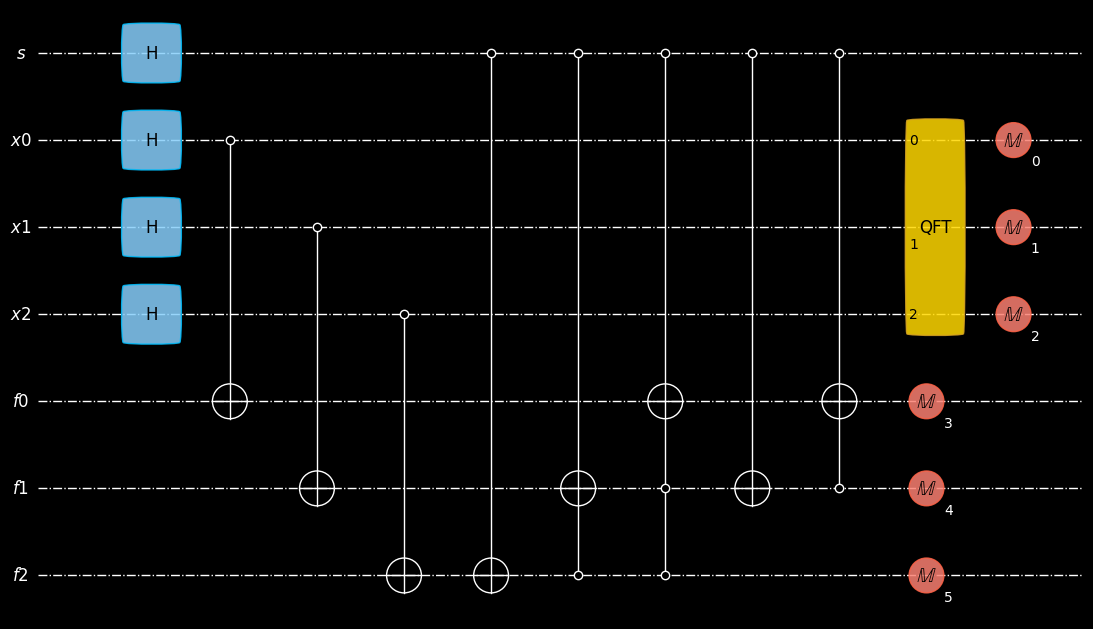

In [3]:
s = ["s"]
x = [f"x{i}" for i in range(3)]
f = [f"f{i}" for i in range(3)]

init = [(Hadamard(), [i]) for i in s + x]

oracle = [
    (CNOT(), x[i : i + 1] + f[i : i + 1]) for i in range(3)
]  # add x to f (true for both s=0 and s =1)

# if s =1 f = x-3 mod 8
for i in reversed(range(3)):  # -1
    oracle.append((QuantumControl((3 - i) * [1], PauliX()), s + f[i + 1 : 3] + [f[i]]))
for i in reversed(range(2)):  # -2
    oracle.append((QuantumControl((2 - i) * [1], PauliX()), s + f[i + 1 : 2] + [f[i]]))

cbits = [f"k{i}" for i in range(3)] + [f"y{i}" for i in range(3)]
coset = Sequence(
    cbits,
    s + x + f,
    init
    + oracle
    + [(Measure(3), f, cbits[3:]), (QFT(3), x), (Measure(3), x, cbits[:3])],
)

plot_mpl(coset, style="geqo_dark")

In [10]:
sim = ensembleSimulatorSymPy(6, 7)
sim.prepareBackend([QFT(3)])
sim.apply(coset, [*range(7)], [*range(6)])

### post-processing
1. obtain the values of k and their corresponding coset state density matrices

In [11]:
coset_rho = {}
for key, item in sim.ensemble.items():
    k = bin2num(
        list(key)[:3]
    )  # measurement outcome of x (parametrizes the coset state)
    y = bin2num(list(key)[3:])  # measurement outcome of f (not important)
    coset_rho[(k, y)] = partialTrace(item[1], [*range(7)], [*range(1, 7)])[0]

In [12]:
coset_rho[(1, 0)]

Matrix([
[            1/2, -I*exp(-I*pi/4)/2],
[I*exp(I*pi/4)/2,               1/2]])

In [13]:
coset_rho[(1, 1)]

Matrix([
[            1/2, -exp(I*pi/4)/2],
[-exp(-I*pi/4)/2,            1/2]])

In [14]:
coset_rho[(3, 2)]

Matrix([
[          1/2, exp(-I*pi/4)/2],
[exp(I*pi/4)/2,            1/2]])

In [15]:
coset_rho[(3, 4)]

Matrix([
[          1/2, exp(-I*pi/4)/2],
[exp(I*pi/4)/2,            1/2]])

##### 2. combine two coset states with the following circuit

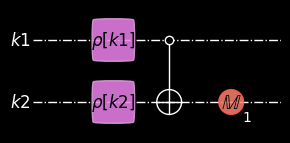

In [4]:
seq = Sequence(
    [1],
    ["k1", "k2"],
    [
        (SetDensityMatrix("k1", 1), ["k1"]),
        (SetDensityMatrix("k2", 1), ["k2"]),
        (CNOT(), ["k1", "k2"]),
        (Measure(1), ["k2"], [1]),
    ],
)
plot_mpl(seq, style="geqo_dark")

In [19]:
import random


def combine(coset_rho, k1, k2):
    seq = Sequence(
        [1],
        [0, 1],
        [
            (SetDensityMatrix("k1", 1), [0]),
            (SetDensityMatrix("k2", 1), [1]),
            (CNOT(), [0, 1]),
            (Measure(1), [1], [1]),
        ],
    )
    sim = ensembleSimulatorSymPy(1, 2)
    sim.setValue("k1", coset_rho[(k1, 0)])
    sim.setValue("k2", coset_rho[(k2, 0)])
    sim.apply(seq, [0, 1], [0])
    b = random.randint(0, 1)
    if b == 1:
        return True, partialTrace(sim.ensemble[(1,)][1], [0, 1], [1])[0]
    else:
        return False, partialTrace(sim.ensemble[(0,)][1], [0, 1], [1])[0]


combine(coset_rho, 1, 3)

(False,
 Matrix([
 [ 1/2, -1/2],
 [-1/2,  1/2]]))

### Sieve procedure 
1. try to eliminate first two least significant bits to get the desired coset state $\ket{\psi_{N/2}} = \ket{\psi_{4}} = \frac{1}{\sqrt{2}}(\ket{0}+(-1)^{d}\ket{1}) $

In [20]:
import math


def ksieve(n, coset_rho):
    """
    n  = log2(N)
    coset_rho: a dictionary of all possible coset states' k values and density matrices
    """
    remove_bits = math.ceil(n**0.5)  # number of bits that will be removed at each stage
    accumulated_bits = 0
    num_samples = 16 ** math.ceil(n**0.5)  # initial number of sample coset states
    stages = math.ceil((n - 1) / remove_bits)
    new_coset_rho = coset_rho
    pool = []  # store the usable coset states for each stage
    stage = 0

    while stage < stages:
        stage += 1
        if stage * remove_bits > n - 1:
            remove_bits = n - 1 - remove_bits * (stage - 1)
        accumulated_bits += remove_bits
        unpairs = []
        pairs = []
        current_coset_rho = new_coset_rho
        new_coset_rho = {}
        if stage == 1:  # first stage
            for _ in range(num_samples):
                k2 = random.randint(0, 2**n - 1)
                remainder = [
                    (k2 - up) % 2**accumulated_bits if k2 != up else 1 for up in unpairs
                ]  # check if another state with the same last few bits exist
                if 0 in remainder:
                    k1 = unpairs[remainder.index(0)]
                    success, new_state = combine(
                        current_coset_rho, k1, k2
                    )  # combine two coset states and get either k1+k2 or k1-k2
                    if success:  # measured k1-k2
                        new_coset_rho[((k1 - k2) % 2**n, 0)] = new_state
                        pairs.append((k1 - k2) % 2**n)
                        unpairs.remove(k1)
                    else:
                        unpairs.remove(k1)
                else:
                    unpairs.append(k2)
        else:  # stage >1
            for k2 in pool:
                remainder = [
                    (k2 - up) % 2**accumulated_bits if k2 != up else 1 for up in unpairs
                ]
                if 0 in remainder:
                    k1 = unpairs[remainder.index(0)]
                    success, new_state = combine(current_coset_rho, k1, k2)
                    if success:
                        new_coset_rho[((k1 - k2) % 2**n, 0)] = new_state
                        pairs.append((k1 - k2) % 2**n)
                        unpairs.remove(k1)
                    else:
                        unpairs.remove(k1)
                else:
                    unpairs.append(k2)

        pool = [
            p for p in pairs
        ]  # make a copy of coset states that will enter the next stage
        print(f"stage {stage} remaining k: {pool}")

        if len(pool) < 2 ** (stages - stage):
            print("sieve failed. restart sampling")
            stage = 0
            accumulated_bits = 0
            new_coset_rho = coset_rho

    if n == 1:
        sieve_state = coset_rho[(1, 0)]
    else:
        sieve_state = new_coset_rho[(pool[0], 0)]
    return sieve_state

In [21]:
sieve_state = ksieve(3, coset_rho)
sieve_state

stage 1 remaining k: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Matrix([
[ 1/2, -1/2],
[-1/2,  1/2]])

2. measure $H\ket{\psi_{4}}$ to determine the parity (or the last bit $d_{0}$) of $d$ 

In [22]:
def measure_sieve(sieve_state):
    seq = Sequence(
        [0],
        [0],
        [(SetDensityMatrix("s", 1), [0]), (Hadamard(), [0]), (Measure(1), [0], [0])],
    )
    sim = ensembleSimulatorSymPy(1, 1)
    sim.setValue("s", sieve_state)
    sim.apply(seq, [0], [0])
    for key, _ in sim.ensemble.items():
        result = key[0]
    return result


d0 = measure_sieve(sieve_state)
d0

1

### Look for the next bit of $d$ by solving a new hidden subgroup problem
The new hidden subgroup is $H^{\prime} = sr^{d^{\prime}} \leq D_{4}$ where $d = 2d^{\prime}+d_{0}$. The goal is trying to find the last bit of $d^{\prime}$ by retrieving the coset state $\ket{\psi_{N^{\prime}/2}} = \ket{\psi_{2}}$ 

</br>

We can construct a new oracle function for this subgroup from the given oracle. The parity of $d_{0}$ determines the mapping from $D_{4}$ to $D_{8}$. 
 
$$\begin{equation}f^{\prime}(s,x^{\prime}) = f(s, 2x^{\prime}+s \cdot d_{0}) = f(s, 2x^{\prime}+s)\end{equation}$$

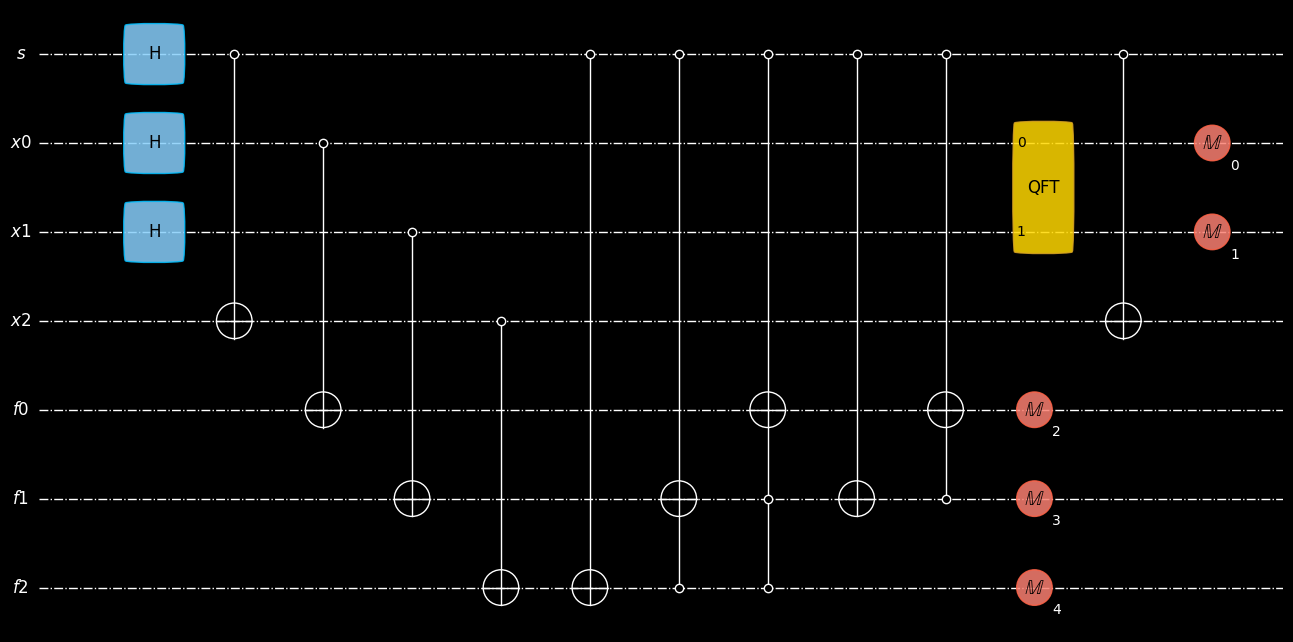

In [ ]:
s = ["s"]
x = [f"x{i}" for i in range(3)]
f = [f"f{i}" for i in range(3)]

init = [(Hadamard(), [i]) for i in s + x[:-1]]

if d0 == 1:  # if d is odd
    mapping = [(CNOT(), s + [x[-1]])]  # mapping from (s,x') in D4 to (s,x) in D8
    inv_mapping = [
        (CNOT(), s + [x[-1]])
    ]  # mapping from (s,x) in D8 back to (s,x') in D4
else:
    mapping = []
    inv_mapping = []

oracle = [
    (CNOT(), x[i : i + 1] + f[i : i + 1]) for i in range(3)
]  # add x to f (true for both s=0 and s =1)

# if s =1 f = x-3 mod 8
for i in reversed(range(3)):  # -1
    oracle.append((QuantumControl((3 - i) * [1], PauliX()), s + f[i + 1 : 3] + [f[i]]))
for i in reversed(range(2)):  # -2
    oracle.append((QuantumControl((2 - i) * [1], PauliX()), s + f[i + 1 : 2] + [f[i]]))

cbits = [f"k{i}" for i in range(2)] + [f"y{i}" for i in range(3)]
coset2 = Sequence(
    cbits,
    s + x + f,
    init
    + mapping
    + oracle
    + [(Measure(3), f, cbits[2:]), (QFT(2), x[:-1])]
    + inv_mapping
    + [(Measure(2), x[:-1], cbits[:2])],
)


plot_mpl(coset2, style="geqo_dark")

In [24]:
sim = ensembleSimulatorSymPy(5, 7)
sim.prepareBackend([QFT(2)])
sim.apply(coset2, [*range(7)], [*range(5)])

In [25]:
# post-process
coset2_rho = {}
for key, item in sim.ensemble.items():
    k = bin2num(
        list(key)[:2]
    )  # measurement outcome of x' (parametrizes the coset state)
    y = bin2num(list(key)[2:])  # measurement outcome of f' (not important)
    coset2_rho[(k, y)] = partialTrace(item[1], [*range(7)], [*range(1, 7)])[0]

In [26]:
# sieve
sieve_state2 = ksieve(2, coset2_rho)
d1 = measure_sieve(sieve_state2)
d1

stage 1 remaining k: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


1

#### Repeat the process by solving a new hidden subgroup problem ($D_{2}$)

$H^{\prime\prime} = sr^{d^{\prime\prime}} \leq D_{2}$ where $d = 4d^{\prime\prime}+2d_{1}+d_{0}$

</br>

with the new oracle function $f^{\prime \prime}$
 
$$\begin{equation}f^{\prime\prime}(s,x^{\prime\prime}) = f(s, 4x^{\prime\prime}+s \cdot (2d_{1}+d_{0})) = f(s, 4x^{\prime\prime}+3s)\end{equation}$$


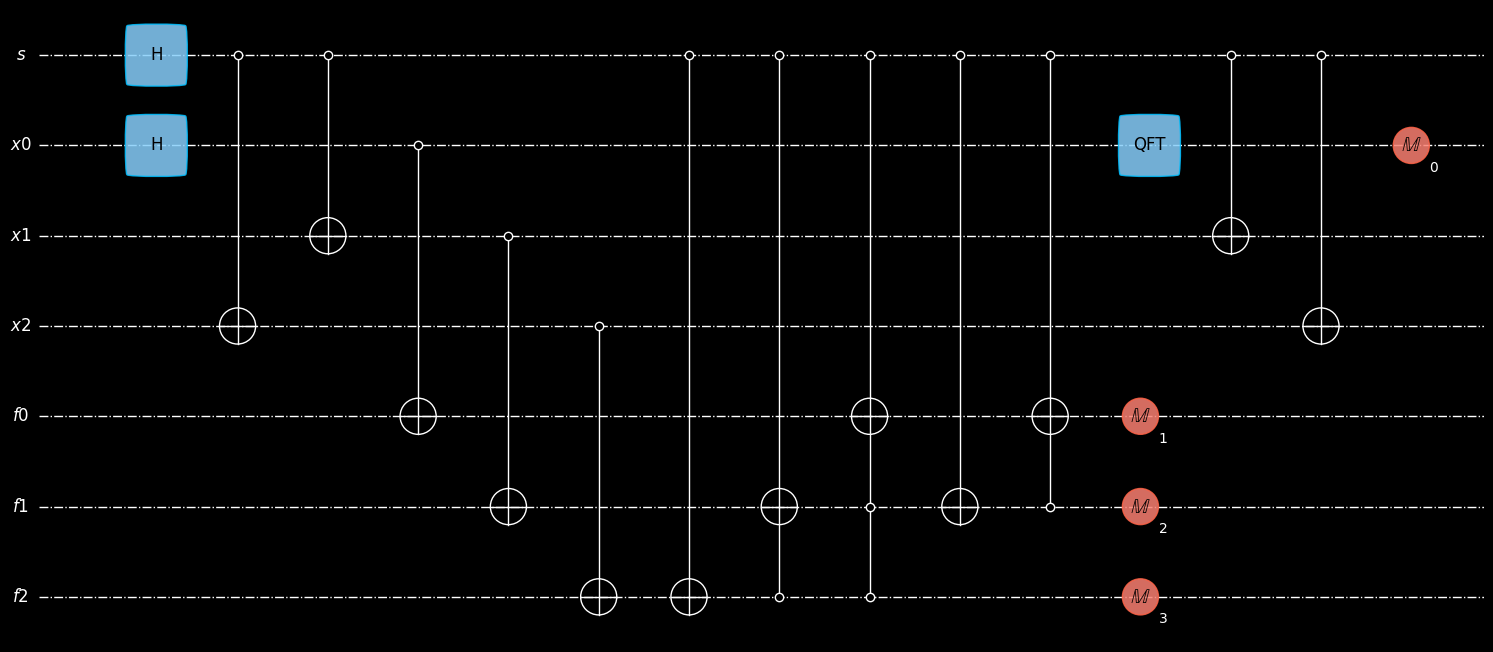

In [ ]:
s = ["s"]
x = [f"x{i}" for i in range(3)]
f = [f"f{i}" for i in range(3)]

init = [(Hadamard(), [i]) for i in s + x[:1]]

if d1 == 1:  # if d is odd
    mapping = [
        (CNOT(), s + [x[-1]]),
        (CNOT(), s + [x[-2]]),
    ]  # mapping from (s,x'') in D2 to (s,x) in D8
    inv_mapping = [
        (CNOT(), s + [x[-2]]),
        (CNOT(), s + [x[-1]]),
    ]  # mapping from (s,x) in D8 back to (s,x'') in D2
else:
    mapping = []
    inv_mapping = []

oracle = [
    (CNOT(), x[i : i + 1] + f[i : i + 1]) for i in range(3)
]  # add x to f (true for both s=0 and s =1)

# if s =1 f = x-3 mod 8
for i in reversed(range(3)):  # -1
    oracle.append((QuantumControl((3 - i) * [1], PauliX()), s + f[i + 1 : 3] + [f[i]]))
for i in reversed(range(2)):  # -2
    oracle.append((QuantumControl((2 - i) * [1], PauliX()), s + f[i + 1 : 2] + [f[i]]))

cbits = [f"k{i}" for i in range(1)] + [f"y{i}" for i in range(3)]
coset3 = Sequence(
    cbits,
    s + x + f,
    init
    + mapping
    + oracle
    + [(Measure(3), f, cbits[1:]), (QFT(1), x[:1])]
    + inv_mapping
    + [(Measure(1), x[:1], cbits[:1])],
)


plot_mpl(coset3, style="geqo_dark")

In [28]:
sim = ensembleSimulatorSymPy(4, 7)
sim.prepareBackend([QFT(1)])
sim.apply(coset3, [*range(7)], [*range(4)])

In [29]:
# post-process
coset3_rho = {}
for key, item in sim.ensemble.items():
    k = bin2num(
        list(key)[:1]
    )  # measurement outcome of x' (parametrizes the coset state)
    y = bin2num(list(key)[1:])  # measurement outcome of f' (not important)
    coset3_rho[(k, y)] = partialTrace(item[1], [*range(7)], [*range(1, 7)])[0]

In [30]:
# sieve
sieve_state3 = ksieve(1, coset3_rho)
d2 = measure_sieve(sieve_state3)
d2

0

#### combine all the bits of d, we yield $d = 4d_{2}+2d_{1}+d_{0} = 3$

In [31]:
d = bin2num([d2, d1, d0])
d

3

### Full Kuperberg's Sieve algorithm for arbitrary dihedral hidden subgroup $H= sr^{d}$ in $D_{N}$

In [7]:
from geqo.gates import Hadamard, CNOT, PauliX
from geqo.algorithms import QFT
from geqo.operations import Measure, QuantumControl
from geqo.initialization.state import SetDensityMatrix
from geqo.core import Sequence
from geqo.simulators import ensembleSimulatorSymPy
from geqo.utils import partialTrace, bin2num, num2bin


def combine(coset_rho, k1, k2):
    seq = Sequence(
        [1],
        [0, 1],
        [
            (SetDensityMatrix("k1", 1), [0]),
            (SetDensityMatrix("k2", 1), [1]),
            (CNOT(), [0, 1]),
            (Measure(1), [1], [1]),
        ],
    )
    sim = ensembleSimulatorSymPy(1, 2)
    sim.setValue("k1", coset_rho[(k1, 0)])
    sim.setValue("k2", coset_rho[(k2, 0)])
    sim.apply(seq, [0, 1], [0])
    b = random.randint(0, 1)
    if b == 1:
        return True, partialTrace(sim.ensemble[(1,)][1], [0, 1], [1])[0]
    else:
        return False, partialTrace(sim.ensemble[(0,)][1], [0, 1], [1])[0]


def ksieve(n, coset_rho):
    """
    n  = log2(N)
    coset_rho: a dictionary of all possible coset states' k values and density matrices
    """
    remove_bits = math.ceil(n**0.5)  # number of bits that will be removed at each stage
    accumulated_bits = 0
    num_samples = 16 ** math.ceil(n**0.5)  # initial number of sample coset states
    stages = math.ceil((n - 1) / remove_bits)
    new_coset_rho = coset_rho
    pool = []  # store the usable coset states for each stage
    stage = 0

    while stage < stages:
        stage += 1
        if stage * remove_bits > n - 1:
            remove_bits = n - 1 - remove_bits * (stage - 1)
        accumulated_bits += remove_bits
        unpairs = []
        pairs = []
        current_coset_rho = new_coset_rho
        new_coset_rho = {}
        if stage == 1:  # first stage
            for _ in range(num_samples):
                k2 = random.randint(0, 2**n - 1)
                remainder = [
                    (k2 - up) % 2**accumulated_bits if k2 != up else 1 for up in unpairs
                ]  # check if another state with the same last few bits exist
                if 0 in remainder:
                    k1 = unpairs[remainder.index(0)]
                    success, new_state = combine(
                        current_coset_rho, k1, k2
                    )  # combine two coset states and get either k1+k2 or k1-k2
                    if success:  # measured k1-k2
                        new_coset_rho[((k1 - k2) % 2**n, 0)] = new_state
                        pairs.append((k1 - k2) % 2**n)
                        unpairs.remove(k1)
                    else:
                        unpairs.remove(k1)
                else:
                    unpairs.append(k2)
        else:  # stage >1
            for k2 in pool:
                remainder = [
                    (k2 - up) % 2**accumulated_bits if k2 != up else 1 for up in unpairs
                ]
                if 0 in remainder:
                    k1 = unpairs[remainder.index(0)]
                    success, new_state = combine(current_coset_rho, k1, k2)
                    if success:
                        new_coset_rho[((k1 - k2) % 2**n, 0)] = new_state
                        pairs.append((k1 - k2) % 2**n)
                        unpairs.remove(k1)
                    else:
                        unpairs.remove(k1)
                else:
                    unpairs.append(k2)

        pool = [
            p for p in pairs
        ]  # make a copy of coset states that will enter the next stage
        print(f"stage {stage} remaining k: {pool}")

        if len(pool) < 2 ** (stages - stage):
            print("sieve failed. restart sampling")
            stage = 0
            accumulated_bits = 0
            new_coset_rho = coset_rho

    if n == 1:
        sieve_state = coset_rho[(1, 0)]
    else:
        sieve_state = new_coset_rho[(pool[0], 0)]
    return sieve_state


def measure_sieve(sieve_state):
    seq = Sequence(
        [0],
        [0],
        [(SetDensityMatrix("s", 1), [0]), (Hadamard(), [0]), (Measure(1), [0], [0])],
    )
    sim = ensembleSimulatorSymPy(1, 1)
    sim.setValue("s", sieve_state)
    sim.apply(seq, [0], [0])
    for key, _ in sim.ensemble.items():
        result = key[0]
    return result


def kuperberg_sieve_algorithm(n, d):
    dbits = []
    for remaining_bits in reversed(range(1, n + 1)):
        ## create coset states
        s = ["s"]
        x = [f"x{i}" for i in range(n)]
        f = [f"f{i}" for i in range(n)]

        init = [(Hadamard(), [i]) for i in s + x[:remaining_bits]]

        if remaining_bits < n:
            xmap_bias = bin2num(
                dbits[::-1]
            )  # d = 2**(n-remaining_bits)* d'+ xmap_bias. this entails the function mapping f'(s,x') = f(s,2**(n-remaining_bits) * x'+xmap_bias * s)
            xmap_bin = num2bin(xmap_bias, n - remaining_bits)
            mapping = [
                (CNOT(), s + [x[remaining_bits + i]])
                for i in range(n - remaining_bits)
                if xmap_bin[i] == 1
            ]
            inv_mapping = mapping[::-1]
        else:  # first iteration
            mapping = []
            inv_mapping = []

        oracle = [
            (CNOT(), x[i : i + 1] + f[i : i + 1]) for i in range(n)
        ]  # add x to f (true for both s=0 and s =1)

        # if s =1 f = x-d mod 2**n
        dlist = num2bin(d, n)  # binary representation of d
        for idx, bit in enumerate(dlist):
            if bit == 1:
                for i in reversed(range(idx + 1)):  # -2 **(n-idx-1)
                    oracle.append(
                        (
                            QuantumControl((idx + 1 - i) * [1], PauliX()),
                            s + f[i + 1 : idx + 1] + [f[i]],
                        )
                    )

        cbits = [f"k{i}" for i in range(remaining_bits)] + [f"y{i}" for i in range(n)]
        coset = Sequence(
            cbits,
            s + x + f,
            init
            + mapping
            + oracle
            + [
                (Measure(n), f, cbits[remaining_bits:]),
                (QFT(remaining_bits), x[:remaining_bits]),
            ]
            + inv_mapping
            + [(Measure(remaining_bits), x[:remaining_bits], cbits[:remaining_bits])],
        )

        sim = ensembleSimulatorSymPy(remaining_bits + n, 2 * n + 1)
        sim.prepareBackend([QFT(remaining_bits)])
        sim.apply(coset, [*range(2 * n + 1)], [*range(remaining_bits + n)])

        ## post-processing of simulation result
        coset_rho = {}
        for key, item in sim.ensemble.items():
            k = bin2num(list(key)[:remaining_bits])
            y = bin2num(list(key)[remaining_bits:])
            coset_rho[(k, y)] = partialTrace(
                item[1], [*range(2 * n + 1)], [*range(1, 2 * n + 1)]
            )[0]

        ## sieving and measure sieve state
        sieve_state = ksieve(remaining_bits, coset_rho)
        dbits.append(measure_sieve(sieve_state))

    return bin2num(dbits[::-1])

In [5]:
kuperberg_sieve_algorithm(2, 1)

stage 1 remaining k: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


1

In [6]:
kuperberg_sieve_algorithm(2, 0)

stage 1 remaining k: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


0

In [7]:
kuperberg_sieve_algorithm(2, 3)

stage 1 remaining k: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


3

In [8]:
kuperberg_sieve_algorithm(3, 6)

stage 1 remaining k: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
stage 1 remaining k: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


6